In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import numpy as np

from google.colab import files

In [14]:
# Uploading data into google colab
# If running locally, list paths to local locations of train and test data

uploaded = files.upload()

!unzip data.zip

train_dir = '/content/data/train'
test_dir = '/content/data/test'

Saving data.zip to data.zip
Archive:  data.zip
   creating: data/
   creating: data/test/
  inflating: __MACOSX/data/._test    
   creating: data/train/
  inflating: __MACOSX/data/._train   
   creating: data/test/PNEUMONIA/
  inflating: __MACOSX/data/test/._PNEUMONIA  
   creating: data/test/NORMAL/
  inflating: __MACOSX/data/test/._NORMAL  
  inflating: data/train/.DS_Store    
  inflating: __MACOSX/data/train/._.DS_Store  
   creating: data/train/PNEUMONIA/
  inflating: __MACOSX/data/train/._PNEUMONIA  
   creating: data/train/NORMAL/
  inflating: __MACOSX/data/train/._NORMAL  
  inflating: data/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg  
  inflating: __MACOSX/data/test/PNEUMONIA/._SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg  
  inflating: data/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg  
  inflating: __MACOSX/data/test/PNEUMONIA/._SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg  
  inflating: data/test/PNEUMONIA/SARS-

In [33]:
# Create training set Datagenerator for image augmentations
# Create separate training and validation sets so we can use test set as a holdout sample

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'

)

val_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)



Found 120 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [34]:
def CNN_model():
  model = Sequential()

  # First Conv Block

  model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
  model.add(LeakyReLU(0.01))
  model.add(MaxPooling2D((2, 2)))

  # Second Conv Block

  model.add(Conv2D(64, (3, 3)))
  model.add(LeakyReLU(0.01))
  model.add(MaxPooling2D((2, 2)))

  # Hidden Layers

  model.add(Flatten())
  model.add(Dense(128))
  model.add(LeakyReLU(0.01))
  model.add(Dropout(0.5))

  # Output

  model.add(Dense(1, activation='sigmoid'))

  # Compile and train model

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()

  # train on generated images, add early stopping callback to prevent overfitting
  history = model.fit(train_generator,
                      epochs = 50,
                      validation_data = val_generator,
                      callbacks = tf.keras.callbacks.EarlyStopping(patience=5))

  return model, history

cnn_model, cnn_history = CNN_model()

# Loss
plt.figure(figsize=(12, 4))
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(12, 4))
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Reset test generator so the generator starts at first image in test set
test_generator.reset()
y_pred_prob = cnn_model.predict(test_generator)

# threshold probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")


#list classes
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())


#classification report for precision, recall, and f1
print(classification_report(y_true, y_pred, target_names=labels))

# confusion matri
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 72, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5352 - loss: 2.6930 - val_accuracy: 0.5000 - val_loss: 0.8223
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 942ms/step - accuracy: 0.6065 - loss: 0.8208 - val_accuracy: 0.5357 - val_loss: 0.6640
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 928ms/step - accuracy: 0.7136 - loss: 0.5577 - val_accuracy: 0.7500 - val_loss: 0.5539
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 937ms/step - accuracy: 0.7115 - loss: 0.5225 - val_accuracy: 0.6429 - val_loss: 0.5656
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8850 - loss: 0.3644 - val_accuracy: 0.6786 - val_loss: 0.5900
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 931ms/step - accuracy: 0.8117 - loss: 0.4241 - val_accuracy: 0.7143 - val_loss: 0.4354
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 863ms/step - accuracy: 0.8685 - loss: 0.2871 - val_accuracy: 0.6429 - val_loss: 0.7113
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 980ms/step - accuracy: 0.8855 - loss: 0.2833 - val_accuracy: 0.8214 - val_loss: 0.403

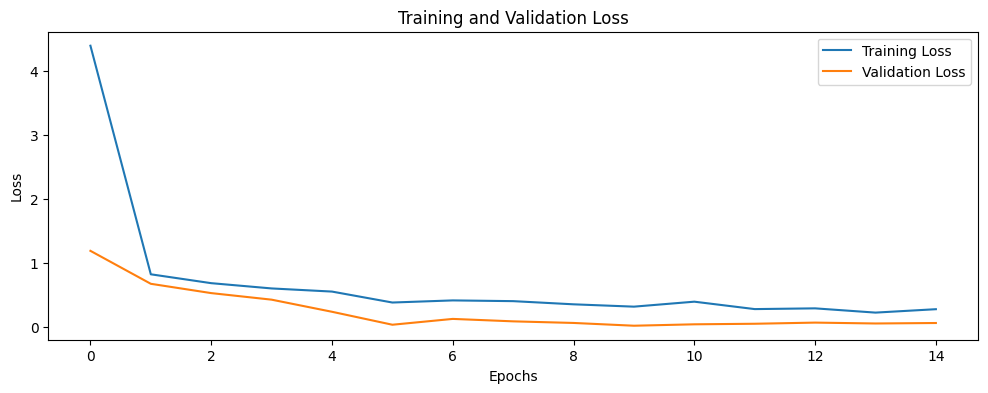

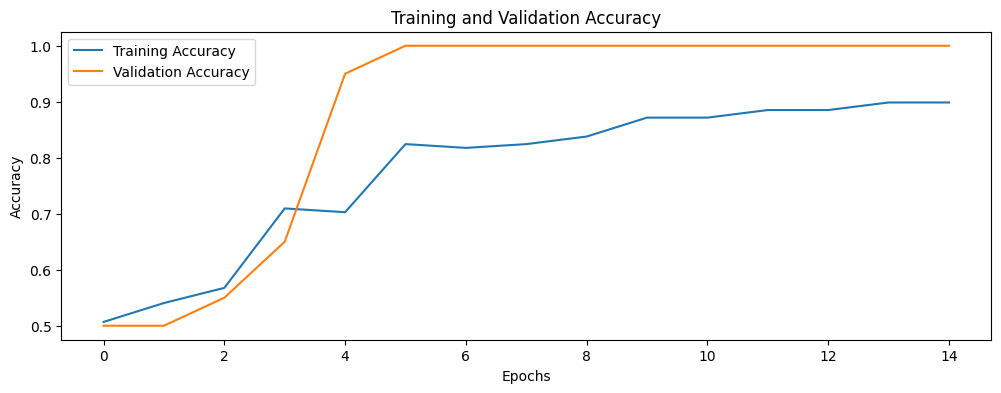

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00        20
   PNEUMONIA       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



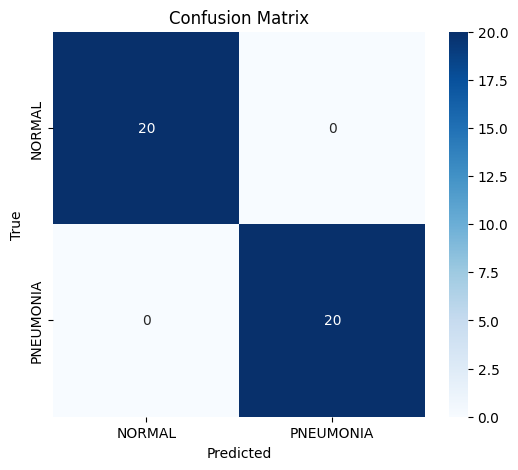